In [ ]:
# Load single centre data

import numpy as np
import os  # Import the os library for file path operations

# Define common directory path
common_path = 'YOUR_PATH_HERE'

# Load files using common directory path
UoE_x = np.loadtxt(os.path.join(common_path, 'Uncorrected_MedianFiltered_SIZEMatched_UoE_x.csv'), delimiter=',')
UoE_y = np.loadtxt(os.path.join(common_path, 'Uncorrected_MedianFiltered_SIZEMatched_UoE_y.csv'), delimiter=',')
UoE_name = np.loadtxt(os.path.join(common_path, 'Uncorrected_MedianFiltered_SIZEMatched_UoE_name.csv'), delimiter=',')
UoE_wn = np.loadtxt(os.path.join(common_path, 'Uncorrected_MedianFiltered_SizeMatched_UoE_wn.csv'), delimiter=',')

# Create dictionary keys

Raw_labels = {
  "NSQ": 0,
  "IM": 1,
  "LGD": 2,
  "HGD": 3,
  "AC": 4
}

UoE_x.shape, UoE_y.shape, UoE_name.shape, UoE_wn.shape

Mounted at /content/drive


((192170, 891), (192170,), (192170,), (891,))

In [ ]:
import numpy as np

def norm_spectra(spec):
    """spec - a matrix of spectra of dimension: number of spectra * wavenumber"""
    """normed_spec = a matrix of 'individual' SNV normalised spectra"""

    normed_spec = np.zeros(spec.shape)

    for i in range(0, spec.shape[0]):
        normed_spec[i] = (spec[i] - np.mean(spec[i]))/np.std(spec[i])

    return normed_spec

In [ ]:
# Dataloader functions

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np

class SpectralDataset(Dataset):
    """
    Builds a dataset of spectral data. Use idxs to specify which samples to use
    for dataset - this allows for random splitting into training, validation,
    and test sets. Instead of passing in filenames for X and y, we can also
    pass in numpy arrays directly.
    """
    def __init__(self, X_fn, y_fn, idxs=None, transform=None):
        if type(X_fn) == str:
            self.X = np.load(X_fn)
        else:
            self.X = X_fn
        if type(y_fn) == str:
            self.y = np.load(y_fn)
        else:
            self.y = y_fn
        if idxs is None: idxs = np.arange(len(self.y))
        self.idxs = idxs
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        i = self.idxs[idx]
        x, y = self.X[i], self.y[i]
        x = np.expand_dims(x, axis=0)
        if self.transform:
            x = self.transform(x)
        return (x, y)


### TRANSFORMS ###


class GetInterval(object):
    """
    Gets an interval of each spectrum.
    """
    def __init__(self, min_idx, max_idx):
        self.min_idx = min_idx
        self.max_idx = max_idx

    def __call__(self, x):
        x = x[:,self.min_idx:self.max_idx]
        return x


class ToFloatTensor(object):
    """
    Converts numpy arrays to float Variables in Pytorch.
    """
    def __call__(self, x):
        x = torch.from_numpy(x).float()
        return x


### TRANSFORMS ###


def spectral_dataloader(X_fn, y_fn, idxs=None, batch_size=10, shuffle=True,
    num_workers=4, min_idx=None, max_idx=None, sampler=None):
    """
    Returns a DataLoader with spectral data.
    """
    transform_list = []
    if min_idx is not None and max_idx is not None:
        transform_list.append(GetInterval(min_idx, max_idx))
    transform_list.append(ToFloatTensor())
    transform = transforms.Compose(transform_list)
    dataset = SpectralDataset(X_fn, y_fn, idxs=idxs, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, sampler=sampler)
    return dataloader


def spectral_dataloaders(X_fn, y_fn, n_train=None, p_train=0.8, p_val=0.1,
    n_test=None, batch_size=10, shuffle=True, num_workers=4, min_idx=None,
    max_idx=None):
    """
    Returns train, val, and test DataLoaders by splitting the dataset randomly.
    Can also take X_fn and y_fn as numpy arrays.
    """
    if type(y_fn) == str:
        idxs = np.arange(len(np.load(y_fn)))
    else:
        idxs = np.arange(len(y_fn))
    np.random.shuffle(idxs)
    if n_train is None: n_train = int(p_train * len(idxs))
    n_val = int(p_val * n_train)
    val_idxs, train_idxs = idxs[:n_val], idxs[n_val:n_train]
    if n_test is None: test_idxs = idxs[n_train:]
    else: test_idxs = idxs[n_train:n_train+n_test]
    trainloader = spectral_dataloader(X_fn, y_fn, train_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    valloader = spectral_dataloader(X_fn, y_fn, val_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    testloader = spectral_dataloader(X_fn, y_fn, test_idxs,
        batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,
        min_idx=min_idx, max_idx=max_idx)
    return (trainloader, valloader, testloader)

In [ ]:
def test_cnn(model, X_test, y_test ):
    test_acc_list = []
    test_loader = spectral_dataloader(X_test,y_test,batch_size = y_test.shape[0])

    model.eval()
    with torch.no_grad():
        test_correct = 0
        test_total = 0
        for test_spectra, test_labels in test_loader:
            test_outputs = model(test_spectra)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_log_loss = metrics.log_loss(test_labels, test_outputs, labels = np.unique(y_train))
            test_accuracy = metrics.accuracy_score(test_labels, test_predicted)

    return test_accuracy, test_log_loss

In [ ]:
# Install thunderSVM to speed up SVM calculations

!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0
!pip install thundersvm

--2023-12-23 10:44:08--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.nvidia.com/downloads/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2023-12-23 10:44:09--  https://developer.nvidia.com/downloads/compute/cuda/9.0/prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?ysWJcdBMXK2Al9k3T1B2XDMfucchXm6Z5_muxz0SIcWWyAGzHuYiefvOI5WsRq5PhNR9GXU-cpfShtrWQEzZ4

In [ ]:
# Custom class for stratification by group.
# Taken from: https://www.kaggle.com/realsid/stratifiedgroupkfold-using-sklearn

from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits
from sklearn.utils.validation import check_random_state, column_or_1d
from sklearn.utils.multiclass import type_of_target
from collections import defaultdict

class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.
    This cross-validation object is a variation of StratifiedKFold attempts to
    return stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class as much as possible given the
    constraint of non-overlapping groups between splits.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.
        This implementation can only shuffle groups that have approximately the
        same y distribution, no global shuffle will be performed.
    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
           [0 0 1 1 1 0 0 0 0 0 0]
     TEST: [3 3 3 6 6 7]
           [1 1 1 0 0 0]
    TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
           [1 1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 2 2 8 8]
           [0 0 1 1 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]
    Notes
    -----
    The implementation is designed to:
    * Mimic the behavior of StratifiedKFold as much as possible for trivial
      groups (e.g. when each group contains only one sample).
    * Be invariant to class label: relabelling ``y = ["Happy", "Sad"]`` to
      ``y = [1, 0]`` should not change the indices generated.
    * Stratify based on samples as much as possible while keeping
      non-overlapping groups constraint. That means that in some cases when
      there is a small number of groups containing a large number of samples
      the stratification will not be possible and the behavior will be close
      to GroupKFold.
    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).
    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    def _iter_test_indices(self, X, y, groups):
        # Implementation is based on this kaggle kernel:
        # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
        # and is a subject to Apache 2.0 License. You may obtain a copy of the
        # License at http://www.apache.org/licenses/LICENSE-2.0
        # Changelist:
        # - Refactored function to a class following scikit-learn KFold
        #   interface.
        # - Added heuristic for assigning group to the least populated fold in
        #   cases when all other criteria are equal
        # - Swtch from using python ``Counter`` to ``np.unique`` to get class
        #   distribution
        # - Added scikit-learn checks for input: checking that target is binary
        #   or multiclass, checking passed random state, checking that number
        #   of splits is less than number of members in each class, checking
        #   that least populated class has more members than there are splits.
        rng = check_random_state(self.random_state)
        y = np.asarray(y)
        type_of_target_y = type_of_target(y)
        allowed_target_types = ('binary', 'multiclass')
        if type_of_target_y not in allowed_target_types:
            raise ValueError(
                'Supported target types are: {}. Got {!r} instead.'.format(
                    allowed_target_types, type_of_target_y))

        y = column_or_1d(y)
        _, y_inv, y_cnt = np.unique(y, return_inverse=True, return_counts=True)
        if np.all(self.n_splits > y_cnt):
            raise ValueError("n_splits=%d cannot be greater than the"
                             " number of members in each class."
                             % (self.n_splits))
        n_smallest_class = np.min(y_cnt)
        if self.n_splits > n_smallest_class:
            warnings.warn(("The least populated class in y has only %d"
                           " members, which is less than n_splits=%d."
                           % (n_smallest_class, self.n_splits)), UserWarning)
        n_classes = len(y_cnt)


        _, groups_inv, groups_cnt = np.unique(
            groups, return_inverse=True, return_counts=True)
        y_counts_per_group = np.zeros((len(groups_cnt), n_classes))
        for class_idx, group_idx in zip(y_inv, groups_inv):
            y_counts_per_group[group_idx, class_idx] += 1

        y_counts_per_fold = np.zeros((self.n_splits, n_classes))
        groups_per_fold = defaultdict(set)

        if self.shuffle:
            rng.shuffle(y_counts_per_group)

        # Stable sort to keep shuffled order for groups with the same
        # class distribution variance
        sorted_groups_idx = np.argsort(-np.std(y_counts_per_group, axis=1),
                                       kind='mergesort')

        for group_idx in sorted_groups_idx:
            group_y_counts = y_counts_per_group[group_idx]
            best_fold = self._find_best_fold(
                y_counts_per_fold=y_counts_per_fold, y_cnt=y_cnt,
                group_y_counts=group_y_counts)
            y_counts_per_fold[best_fold] += group_y_counts
            groups_per_fold[best_fold].add(group_idx)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group_idx in enumerate(groups_inv)
                            if group_idx in groups_per_fold[i]]
            yield test_indices

    def _find_best_fold(
            self, y_counts_per_fold, y_cnt, group_y_counts):
        best_fold = None
        min_eval = np.inf
        min_samples_in_fold = np.inf
        for i in range(self.n_splits):
            y_counts_per_fold[i] += group_y_counts
            # Summarise the distribution over classes in each proposed fold
            std_per_class = np.std(
                y_counts_per_fold / y_cnt.reshape(1, -1),
                axis=0)
            y_counts_per_fold[i] -= group_y_counts
            fold_eval = np.mean(std_per_class)
            samples_in_fold = np.sum(y_counts_per_fold[i])
            is_current_fold_better = (
                fold_eval < min_eval or
                np.isclose(fold_eval, min_eval)
                and samples_in_fold < min_samples_in_fold
            )
            if is_current_fold_better:
                min_eval = fold_eval
                min_samples_in_fold = samples_in_fold
                best_fold = i
        return best_fold

In [ ]:
def truncate_spectra_to_region(wn, spectra, trunc_start = 400, trunc_end = 1800):
    """
    Function to truncate spectra within a specified region, default to the fingerprint region
    Inputs:
        wn - an array (vector) of the wavenumbers
        spectra - an array (matrix) of spectra (spectra in the rows)
        trunc_start - start of wavenumber region to be included
        trunc_end - end of wavenumber region to be included
    Outputs:

    """

    if trunc_start > trunc_end:
        print("ERROR: Start of region must be lower than end of region")
        pass

    closest_top_wn = min(wn, key=lambda x:abs(x-trunc_end))
    closest_bottom_wn = min(wn, key=lambda x:abs(x-trunc_start))

    max_wn = np.where(wn == closest_top_wn)
    min_wn = np.where(wn == closest_bottom_wn)

    trunc_spectra = spectra[:,np.squeeze(max_wn):np.squeeze(min_wn)]
    trunc_wn = wn[np.squeeze(max_wn):np.squeeze(min_wn)]

    return trunc_spectra, trunc_wn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def create_straight_line(wn, start, end):
    """
    Creates a straight line passing through the given start, end, and mid points.
    """
    #wn = np.linspace(450, 1800, length)

    #midpoint_index = len(wn) // 2
    #midpoint_wn = wn[midpoint_index]

    #midpoint_wn = np.median(UoE_wn)

    value = wn.min() + ( wn.max() - wn.min() )/ 2
    closest_value = wn[np.abs(wn - value).argmin()]
    index = np.where(wn == closest_value)[0]
    midpoint_wn = wn[index].item()

    x_vals = np.array([wn[0], midpoint_wn, wn[-1]])
    y_vals = np.array([start, 1, end])
    slope, intercept = np.polyfit(x_vals, y_vals, deg=1)

    return slope * (wn - x_vals[1]) + y_vals[1]

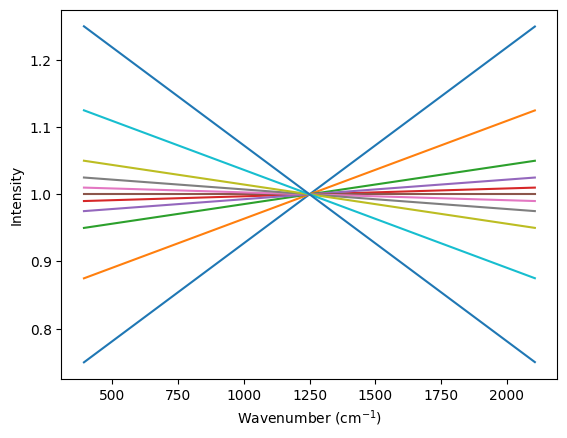

In [ ]:
p_values = [-50,-25,-10, -2, -5, 0, 2, 5, 10, 25, 50]
for p in p_values:
    start = 1 - p/200
    end = 1 + p/200
    line = create_straight_line(UoE_wn, start, end)
    plt.plot(UoE_wn, line)

plt.xlabel('Wavenumber (cm$^{-1}$)')
plt.ylabel('Intensity')
plt.show()

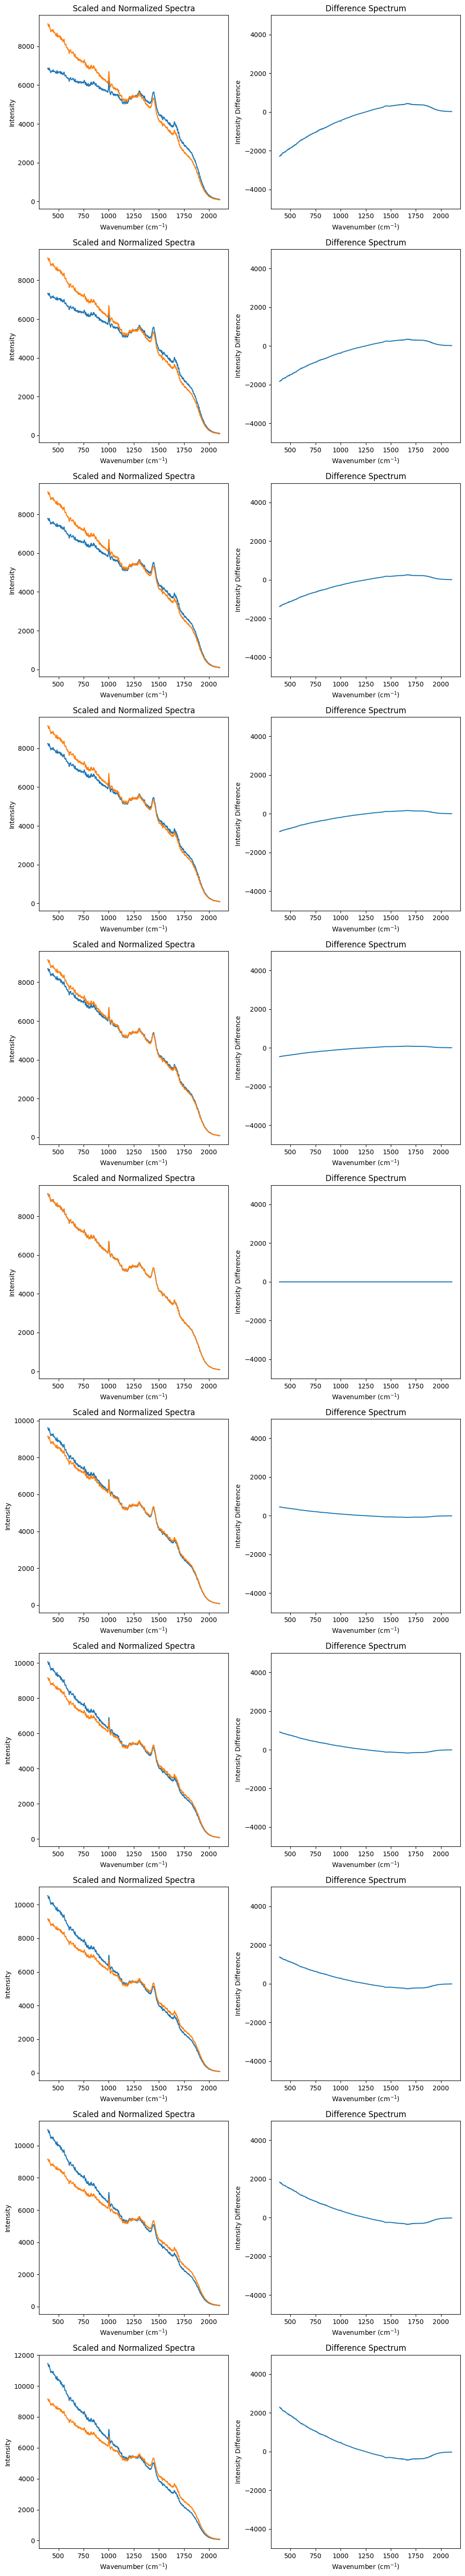

In [ ]:
import matplotlib.pyplot as plt

p_values = [ -50,-40,-30, -20, -10, 0, 10, 20, 30, 40, 50]

fig, axs = plt.subplots(len(p_values), 2, figsize=(10, len(p_values) * 5))

for i, p in enumerate(p_values):
    start = 1 - p / 200
    end = 1 + p / 200

    line = create_straight_line(UoE_wn, start, end)
    X_scaled = line * UoE_x
    diff_spectrum = X_scaled[10, :] - UoE_x[10, :]

    ax1 = axs[i, 0]
    ax1.plot(UoE_wn, X_scaled[10, :])
    ax1.plot(UoE_wn, UoE_x[10, :])
    ax1.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax1.set_ylabel('Intensity')
    ax1.set_title('Scaled and Normalized Spectra')

    ax2 = axs[i, 1]
    ax2.plot(UoE_wn, diff_spectrum)
    ax2.set_xlabel('Wavenumber (cm$^{-1}$)')
    ax2.set_ylabel('Intensity Difference')
    ax2.set_title('Difference Spectrum')
    ax2.set_ylim([-5000, 5000])

plt.tight_layout()
plt.show()

In [ ]:
### Trunacate data to 1800cm

UoE_x, UoE_wn = truncate_spectra_to_region(UoE_wn, UoE_x, trunc_start = 400, trunc_end = 1800)

In [ ]:
# Define the CNN

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 20, kernel_size=7, stride=1, padding=0),
            nn.BatchNorm1d(20),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=3))
        self.layer2 = nn.Sequential(
            nn.Conv1d(20, 40, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm1d(40),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv1d(40, 40, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm1d(40), #60
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1))
        self.fc1 = nn.Linear(4280 , 60)
        self.fc2 = nn.Linear(60, 5)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.2)
        out = self.fc2(out)

        return out

In [ ]:
def test_a_batch(model, X, y, cuda = True, batch_size = 16):

    """
    Function to take in a Pytorch neural network and some data and output the accuracy,
    confusion matrix and log loss

    Inputs:
        model - pytorch model
        X - data inputs compatible with the above model
        y - data labels
        batch_size - set low to ensure compatability even with poor memory CPUs

    Outputs:
        test_log_loss - log loss
        test_accuracy - accuracy
        con_mat - confusion matrix

    """

    test_loader = spectral_dataloader(X, y, batch_size = batch_size, shuffle=False)

    y_test_clas = get_predictions(model, test_loader, cuda, get_probs=False)
    y_test_pred = get_predictions(model, test_loader, cuda, get_probs=True)

    test_log_loss = metrics.log_loss(y, y_test_pred, labels = np.unique(y_test))
    test_accuracy = metrics.accuracy_score(y, y_test_clas)
    con_mat = confusion_matrix(y, y_test_clas)

    return test_log_loss, test_accuracy, con_mat

In [ ]:
def get_predictions(model, dataloader, cuda, get_probs=False):
    preds = []
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        if cuda: inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = Variable(inputs), Variable(targets.long())
        outputs = model(inputs)
        if get_probs:
            probs = torch.nn.functional.softmax(outputs, dim=1)
            if cuda: probs = probs.data.cpu().numpy()
            else: probs = probs.data.numpy()
            preds.append(probs)
        else:
            _, predicted = torch.max(outputs.data, 1)
            if cuda: predicted = predicted.cpu()
            preds += list(predicted.numpy().ravel())
    if get_probs:
        return np.vstack(preds)
    else:
        return np.array(preds)

In [ ]:
# Cuda enabled version.

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def train_cnn(model, X_train, y_train, X_test, y_test, learning_rate = 0.0001, beta1 = 0.9, beta2 = 0.999, num_epochs = 30, batch_size = 16, early_stop = 5,weightedLoss = False, learning_curves = True, cuda = False):

    train_loader = spectral_dataloader(X_train,y_train,batch_size = batch_size, shuffle=True) # requires dataloader functions
    test_loader = spectral_dataloader(X_test,y_test,batch_size = batch_size, shuffle=False)

    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    test_acc_list = []
    test_logloss = []
    test_accuracy = []

            # Loss and optimizer

  #torch.manual_seed(3407) # If we want to fix random seed
    model = model() #this should be called before running the function so is not needed here
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    criterion = nn.CrossEntropyLoss()
    if weightedLoss:
        weight = np.squeeze(get_data_weights(y_train)).to(device) # Need to send all variables used in optimisation to the GPU, including this weights
        criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))
    cuda = torch.cuda.is_available()

    if cuda:
      model.cuda()

    # early stopping set-up
    best_val = 0
    no_improvement = 0
    max_no_improvement = early_stop

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        test_outputs_list = []
        test_predicted_list = []
        test_labels_list = []
        for i, (spectra, labels) in enumerate(train_loader):
            spectra, labels = spectra.cuda(), labels.cuda()
            # Run the forward pass

            outputs = model(spectra)
            loss = criterion(outputs, labels.long())
            loss_list.append(loss.item())

            # Backprop and perform Adam optimisation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            acc_list.append(correct / total)

            if (i + 1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.3f}, Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), (correct / total) * 100))

                # Test the model
        print('Testing epoch {}'.format(epoch + 1))
        model.eval()
        with torch.no_grad():
            test_correct = 0
            test_total = 0
            for test_spectra, test_labels in test_loader:
                test_spectra, test_labels = test_spectra.cuda(), test_labels.cuda()
                test_outputs = model(test_spectra)
                test_outputs_list.append(test_outputs)
                test_labels_list.append(test_labels)
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_predicted_list.append(test_predicted)
                test_total += test_labels.size(0)
                test_correct += (test_predicted == test_labels).sum().item()
                acc_te = test_correct / test_total
            test_acc_list.append(acc_te)

            print('Epoch {}: Test Accuracy {} %'.format(epoch+1,(acc_te) * 100))


                # Check performance for early stopping
        if acc_te > best_val or epoch == 0:
            best_val = acc_te
            no_improvement = 0
        else:
            no_improvement += 1
        if no_improvement >= max_no_improvement:
            print('Finished early after {} epochs!'.format(epoch+1))
            break

    # Final train score on a single batch
    train_log_loss, train_accuracy, _ = test_a_batch(model ,X_train, y_train, batch_size )

    # Final test score on a single batch
    test_log_loss, test_accuracy, con_mat = test_a_batch(model ,X_test, y_test, batch_size )

    print('Final Training Accuracy {} %'.format((train_accuracy) * 100))
    print('Final Test Accuracy {} %'.format((test_accuracy) * 100))

    if learning_curves:
        plot_learning_curve(acc_list, test_acc_list, epoch)

    return model, con_mat, test_log_loss, test_accuracy, train_log_loss, train_accuracy, test_outputs_list, test_predicted_list



In [ ]:
from thundersvm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import metrics
from sklearn.decomposition import PCA

lda_accuracy_by_order = []
svm_accuracy_by_order = []
cnn_accuracy_by_order = []

# Hyperparameters
batch_size = 184
n_epochs = 60
num_classes = 5
learning_rate = 5e-05

counter = 0
n_repeats = 5
folds = 3
best_pc = 11
c = 0.9
gamma = 0.01

p_values = [ -50, -40,-30,-20, -10, 0, 10, 20, 30, 40, 50]
lda_no_noise_acc = []
svm_no_noise_acc = []
cnn_no_noise_acc = []


while counter < n_repeats*folds:

    sgkf = StratifiedGroupKFold(folds, shuffle = True)
    print("Fold:{}".format(counter+1))

    for train_index, test_index in sgkf.split(UoE_x, UoE_y, UoE_name):

        X_train, X_test = UoE_x[train_index], UoE_x[test_index]
        y_train, y_test = UoE_y[train_index], UoE_y[test_index]
        group_train = UoE_name[train_index]

        print(np.unique(y_train))
        print(np.unique(y_test))
        if len(np.unique(y_train)) != len(np.unique(UoE_y)) or len(np.unique(y_test)) != len(np.unique(UoE_y)):
          print("Skipping Fold due to indaquate training or testing classes")
          break

        counter = counter+1

        X_train = norm_spectra(X_train)

            # Train PCA-LDA
        print("Training PCA-LDA")

        pca = PCA(n_components = 11) # This chooses the best performing number of PCs
        lda = LDA()

        X_train_pc = pca.fit_transform(X_train)
        lda.fit(X_train_pc, np.squeeze(y_train))
        lda_test_accuracy = []
        y_test_clas = lda.predict(pca.transform(norm_spectra(X_test)))
        lda_no_noise_acc.append( metrics.accuracy_score(np.squeeze(y_test), y_test_clas ) )

            # Train SVM
        print("Training SVM")
        svm = SVC(probability = True, kernel='rbf', C = c, gamma = gamma)
        svm.fit(X_train, np.squeeze(y_train))

        svm_test_accuracy = []
        y_test_clas = svm.predict(norm_spectra(X_test))
        svm_no_noise_acc.append( metrics.accuracy_score(np.squeeze(y_test), y_test_clas ) )

            # Train CNN
        print("Training CNN")
        temp_X_test = norm_spectra(X_test) # Take a temp test set which has not had noise added for the training process
        trained_ConvNet, _, _, acc, _, _, _, _ = train_cnn(ConvNet, X_train, y_train, temp_X_test, y_test, learning_rate = learning_rate, num_epochs = n_epochs, batch_size = batch_size, early_stop = 5, weightedLoss = False, learning_curves = False, cuda = True)

        cnn_test_accuracy = []
        cnn_no_noise_acc.append(acc)

        for p in p_values:
            start = 1 - p/200
            end = 1 + p/200
            line = create_straight_line(UoE_wn, start, end)

            print("Testing: P-value {}".format(p))

            X_scaled = line*X_test
            X_test_scaled_normed = norm_spectra(X_scaled)

                # LDA test
            X_test_pca = pca.transform(X_test_scaled_normed)
            outer_y_test_clas = lda.predict(X_test_pca)
            acc = metrics.accuracy_score(np.squeeze(y_test), outer_y_test_clas )
            lda_test_accuracy.append(acc)

                # SVM test
            outer_y_test_clas = svm.predict(X_test_scaled_normed)
            acc = metrics.accuracy_score(np.squeeze(y_test), outer_y_test_clas )
            svm_test_accuracy.append(acc)

                # CNN test

            _, acc, _ = test_a_batch(trained_ConvNet, X_test_scaled_normed, y_test )
            cnn_test_accuracy.append(acc)


        lda_accuracy_by_order.append( lda_test_accuracy )
        svm_accuracy_by_order.append( svm_test_accuracy )
        cnn_accuracy_by_order.append( cnn_test_accuracy )


Fold:1
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/698], Loss: 0.816, Training Accuracy: 69.02%
Epoch [1/60], Step [200/698], Loss: 0.632, Training Accuracy: 77.17%
Epoch [1/60], Step [300/698], Loss: 0.589, Training Accuracy: 76.63%
Epoch [1/60], Step [400/698], Loss: 0.449, Training Accuracy: 81.52%
Epoch [1/60], Step [500/698], Loss: 0.554, Training Accuracy: 78.80%
Epoch [1/60], Step [600/698], Loss: 0.437, Training Accuracy: 83.70%
Testing epoch 1
Epoch 1: Test Accuracy 49.63894675835278 %
Epoch [2/60], Step [100/698], Loss: 0.361, Training Accuracy: 86.96%
Epoch [2/60], Step [200/698], Loss: 0.341, Training Accuracy: 86.96%
Epoch [2/60], Step [300/698], Loss: 0.406, Training Accuracy: 85.33%
Epoch [2/60], Step [400/698], Loss: 0.295, Training Accuracy: 90.76%
Epoch [2/60], Step [500/698], Loss: 0.346, Training Accuracy: 86.41%
Epoch [2/60], Step [600/698], Loss: 0.314, Training Accuracy: 89.13%
Testing epoch 2
Epoch 2: Test Accuracy 49.3225356745665 %
Epoch [3/60], Step [100/698], Loss: 0.351, Training Acc

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 93.39120541732578 %
Final Test Accuracy 50.79807647123322 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/692], Loss: 1.055, Training Accuracy: 58.70%
Epoch [1/60], Step [200/692], Loss: 0.911, Training Accuracy: 65.76%
Epoch [1/60], Step [300/692], Loss: 0.849, Training Accuracy: 69.57%
Epoch [1/60], Step [400/692], Loss: 0.808, Training Accuracy: 69.57%
Epoch [1/60], Step [500/692], Loss: 0.737, Training Accuracy: 72.83%
Epoch [1/60], Step [600/692], Loss: 0.603, Training Accuracy: 78.80%
Testing epoch 1
Epoch 1: Test Accuracy 73.0459133431807 %
Epoch [2/60], Step [100/692], Loss: 0.559, Training Accuracy: 83.15%
Epoch [2/60], Step [200/692], Loss: 0.624, Training Accuracy: 77.17%
Epoch [2/60], Step [300/692], Loss: 0.550, Training Accuracy: 80.98%
Epoch [2/60], Step [400/692], Loss: 0.531, Training Accuracy: 83.15%
Epoch [2/60], Step [500/692], Loss: 0.616, Training Accuracy: 73.91%
Epoch [2/60], Step [600/692], Loss: 0.524, Training Accuracy: 80.43%
Testing epoch 2
Epoch 2: Test Accuracy 76.14475627769572 %
Epoch [3/60], Step [100/692], Loss: 0.515, Training Acc

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 90.26010788029376 %
Final Test Accuracy 76.36170605612999 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/701], Loss: 1.038, Training Accuracy: 57.07%
Epoch [1/60], Step [200/701], Loss: 0.892, Training Accuracy: 66.30%
Epoch [1/60], Step [300/701], Loss: 0.743, Training Accuracy: 75.54%
Epoch [1/60], Step [400/701], Loss: 0.629, Training Accuracy: 81.52%
Epoch [1/60], Step [500/701], Loss: 0.703, Training Accuracy: 75.54%
Epoch [1/60], Step [600/701], Loss: 0.628, Training Accuracy: 77.72%
Epoch [1/60], Step [700/701], Loss: 0.602, Training Accuracy: 78.80%
Testing epoch 1
Epoch 1: Test Accuracy 65.52568009220519 %
Epoch [2/60], Step [100/701], Loss: 0.492, Training Accuracy: 84.24%
Epoch [2/60], Step [200/701], Loss: 0.611, Training Accuracy: 75.00%
Epoch [2/60], Step [300/701], Loss: 0.536, Training Accuracy: 82.07%
Epoch [2/60], Step [400/701], Loss: 0.502, Training Accuracy: 78.80%
Epoch [2/60], Step [500/701], Loss: 0.438, Training Accuracy: 85.87%
Epoch [2/60], Step [600/701], Loss: 0.494, Training Accuracy: 84.78%
Epoch [2/60], Step [700/701], Loss: 0.487, T

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 89.52364689171253 %
Final Test Accuracy 61.66695612359284 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Fold:4
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/671], Loss: 1.001, Training Accuracy: 63.04%
Epoch [1/60], Step [200/671], Loss: 0.727, Training Accuracy: 73.91%
Epoch [1/60], Step [300/671], Loss: 0.691, Training Accuracy: 76.63%
Epoch [1/60], Step [400/671], Loss: 0.601, Training Accuracy: 75.00%
Epoch [1/60], Step [500/671], Loss: 0.456, Training Accuracy: 87.50%
Epoch [1/60], Step [600/671], Loss: 0.456, Training Accuracy: 84.78%
Testing epoch 1
Epoch 1: Test Accuracy 63.81013339540026 %
Epoch [2/60], Step [100/671], Loss: 0.507, Training Accuracy: 80.43%
Epoch [2/60], Step [200/671], Loss: 0.441, Training Accuracy: 83.70%
Epoch [2/60], Step [300/671], Loss: 0.350, Training Accuracy: 89.67%
Epoch [2/60], Step [400/671], Loss: 0.449, Training Accuracy: 83.70%
Epoch [2/60], Step [500/671], Loss: 0.549, Training Accuracy: 81.52%
Epoch [2/60], Step [600/671], Loss: 0.367, Training Accuracy: 85.87%
Testing epoch 2
Epoch 2: Test Accuracy 63.778130136886666 %
Epoch [3/60], Step [100/671], Loss: 0.440, Training A

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 90.53853694896578 %
Final Test Accuracy 60.75236751378322 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/674], Loss: 1.047, Training Accuracy: 60.87%
Epoch [1/60], Step [200/674], Loss: 0.836, Training Accuracy: 68.48%
Epoch [1/60], Step [300/674], Loss: 0.782, Training Accuracy: 71.20%
Epoch [1/60], Step [400/674], Loss: 0.606, Training Accuracy: 77.17%
Epoch [1/60], Step [500/674], Loss: 0.601, Training Accuracy: 78.80%
Epoch [1/60], Step [600/674], Loss: 0.576, Training Accuracy: 76.63%
Testing epoch 1
Epoch 1: Test Accuracy 72.37057858983368 %
Epoch [2/60], Step [100/674], Loss: 0.569, Training Accuracy: 78.26%
Epoch [2/60], Step [200/674], Loss: 0.577, Training Accuracy: 82.07%
Epoch [2/60], Step [300/674], Loss: 0.625, Training Accuracy: 76.09%
Epoch [2/60], Step [400/674], Loss: 0.500, Training Accuracy: 79.89%
Epoch [2/60], Step [500/674], Loss: 0.508, Training Accuracy: 79.89%
Epoch [2/60], Step [600/674], Loss: 0.584, Training Accuracy: 78.80%
Testing epoch 2
Epoch 2: Test Accuracy 72.60482548606231 %
Epoch [3/60], Step [100/674], Loss: 0.473, Training Ac

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 89.46199925726188 %
Final Test Accuracy 72.5330873740923 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/745], Loss: 0.938, Training Accuracy: 66.85%
Epoch [1/60], Step [200/745], Loss: 0.874, Training Accuracy: 67.39%
Epoch [1/60], Step [300/745], Loss: 0.591, Training Accuracy: 81.52%
Epoch [1/60], Step [400/745], Loss: 0.588, Training Accuracy: 80.98%
Epoch [1/60], Step [500/745], Loss: 0.737, Training Accuracy: 69.02%
Epoch [1/60], Step [600/745], Loss: 0.667, Training Accuracy: 72.83%
Epoch [1/60], Step [700/745], Loss: 0.515, Training Accuracy: 79.89%
Testing epoch 1
Epoch 1: Test Accuracy 62.84672459771783 %
Epoch [2/60], Step [100/745], Loss: 0.524, Training Accuracy: 82.07%
Epoch [2/60], Step [200/745], Loss: 0.663, Training Accuracy: 75.00%
Epoch [2/60], Step [300/745], Loss: 0.579, Training Accuracy: 76.09%
Epoch [2/60], Step [400/745], Loss: 0.464, Training Accuracy: 84.24%
Epoch [2/60], Step [500/745], Loss: 0.608, Training Accuracy: 72.83%
Epoch [2/60], Step [600/745], Loss: 0.474, Training Accuracy: 84.24%
Epoch [2/60], Step [700/745], Loss: 0.511, T

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 89.61013374973548 %
Final Test Accuracy 70.68374362788673 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Fold:7
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/685], Loss: 1.019, Training Accuracy: 66.85%
Epoch [1/60], Step [200/685], Loss: 0.937, Training Accuracy: 63.59%
Epoch [1/60], Step [300/685], Loss: 0.719, Training Accuracy: 72.83%
Epoch [1/60], Step [400/685], Loss: 0.721, Training Accuracy: 73.37%
Epoch [1/60], Step [500/685], Loss: 0.785, Training Accuracy: 69.02%
Epoch [1/60], Step [600/685], Loss: 0.743, Training Accuracy: 69.02%
Testing epoch 1
Epoch 1: Test Accuracy 71.11856113804194 %
Epoch [2/60], Step [100/685], Loss: 0.611, Training Accuracy: 77.17%
Epoch [2/60], Step [200/685], Loss: 0.611, Training Accuracy: 76.09%
Epoch [2/60], Step [300/685], Loss: 0.653, Training Accuracy: 72.28%
Epoch [2/60], Step [400/685], Loss: 0.602, Training Accuracy: 78.80%
Epoch [2/60], Step [500/685], Loss: 0.621, Training Accuracy: 80.43%
Epoch [2/60], Step [600/685], Loss: 0.540, Training Accuracy: 79.35%
Testing epoch 2
Epoch 2: Test Accuracy 68.79747504492668 %
Epoch [3/60], Step [100/685], Loss: 0.546, Training Ac

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 85.42846027423363 %
Final Test Accuracy 68.34443286669989 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/690], Loss: 0.892, Training Accuracy: 63.59%
Epoch [1/60], Step [200/690], Loss: 0.682, Training Accuracy: 74.46%
Epoch [1/60], Step [300/690], Loss: 0.627, Training Accuracy: 71.20%
Epoch [1/60], Step [400/690], Loss: 0.433, Training Accuracy: 84.24%
Epoch [1/60], Step [500/690], Loss: 0.502, Training Accuracy: 80.43%
Epoch [1/60], Step [600/690], Loss: 0.415, Training Accuracy: 83.15%
Testing epoch 1
Epoch 1: Test Accuracy 55.13036293530816 %
Epoch [2/60], Step [100/690], Loss: 0.439, Training Accuracy: 82.61%
Epoch [2/60], Step [200/690], Loss: 0.420, Training Accuracy: 82.61%
Epoch [2/60], Step [300/690], Loss: 0.630, Training Accuracy: 77.17%
Epoch [2/60], Step [400/690], Loss: 0.393, Training Accuracy: 83.15%
Epoch [2/60], Step [500/690], Loss: 0.417, Training Accuracy: 82.07%
Epoch [2/60], Step [600/690], Loss: 0.312, Training Accuracy: 89.67%
Testing epoch 2
Epoch 2: Test Accuracy 55.93212558908134 %
Epoch [3/60], Step [100/690], Loss: 0.430, Training Ac

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 94.77187061365464 %
Final Test Accuracy 59.43601199583818 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/716], Loss: 0.913, Training Accuracy: 63.04%
Epoch [1/60], Step [200/716], Loss: 0.771, Training Accuracy: 72.83%
Epoch [1/60], Step [300/716], Loss: 0.626, Training Accuracy: 78.80%
Epoch [1/60], Step [400/716], Loss: 0.556, Training Accuracy: 79.35%
Epoch [1/60], Step [500/716], Loss: 0.561, Training Accuracy: 81.52%
Epoch [1/60], Step [600/716], Loss: 0.569, Training Accuracy: 75.00%
Epoch [1/60], Step [700/716], Loss: 0.549, Training Accuracy: 82.61%
Testing epoch 1
Epoch 1: Test Accuracy 62.67513821272382 %
Epoch [2/60], Step [100/716], Loss: 0.464, Training Accuracy: 80.98%
Epoch [2/60], Step [200/716], Loss: 0.513, Training Accuracy: 82.07%
Epoch [2/60], Step [300/716], Loss: 0.575, Training Accuracy: 80.43%
Epoch [2/60], Step [400/716], Loss: 0.422, Training Accuracy: 85.87%
Epoch [2/60], Step [500/716], Loss: 0.461, Training Accuracy: 83.70%
Epoch [2/60], Step [600/716], Loss: 0.437, Training Accuracy: 84.24%
Epoch [2/60], Step [700/716], Loss: 0.398, T

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 91.5903477104313 %
Final Test Accuracy 68.72349203729681 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Fold:10
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/742], Loss: 0.925, Training Accuracy: 67.93%
Epoch [1/60], Step [200/742], Loss: 0.880, Training Accuracy: 65.22%
Epoch [1/60], Step [300/742], Loss: 0.699, Training Accuracy: 72.83%
Epoch [1/60], Step [400/742], Loss: 0.601, Training Accuracy: 80.43%
Epoch [1/60], Step [500/742], Loss: 0.553, Training Accuracy: 77.17%
Epoch [1/60], Step [600/742], Loss: 0.710, Training Accuracy: 72.28%
Epoch [1/60], Step [700/742], Loss: 0.549, Training Accuracy: 79.89%
Testing epoch 1
Epoch 1: Test Accuracy 63.74914840976729 %
Epoch [2/60], Step [100/742], Loss: 0.503, Training Accuracy: 84.24%
Epoch [2/60], Step [200/742], Loss: 0.436, Training Accuracy: 86.96%
Epoch [2/60], Step [300/742], Loss: 0.554, Training Accuracy: 81.52%
Epoch [2/60], Step [400/742], Loss: 0.491, Training Accuracy: 82.61%
Epoch [2/60], Step [500/742], Loss: 0.504, Training Accuracy: 83.15%
Epoch [2/60], Step [600/742], Loss: 0.597, Training Accuracy: 76.09%
Epoch [2/60], Step [700/742], Loss: 0.449, T

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 88.73027743562673 %
Final Test Accuracy 60.254939223349716 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/667], Loss: 0.955, Training Accuracy: 63.59%
Epoch [1/60], Step [200/667], Loss: 0.701, Training Accuracy: 77.72%
Epoch [1/60], Step [300/667], Loss: 0.590, Training Accuracy: 79.35%
Epoch [1/60], Step [400/667], Loss: 0.609, Training Accuracy: 79.89%
Epoch [1/60], Step [500/667], Loss: 0.538, Training Accuracy: 78.26%
Epoch [1/60], Step [600/667], Loss: 0.484, Training Accuracy: 86.41%
Testing epoch 1
Epoch 1: Test Accuracy 56.27600904286722 %
Epoch [2/60], Step [100/667], Loss: 0.471, Training Accuracy: 82.07%
Epoch [2/60], Step [200/667], Loss: 0.443, Training Accuracy: 84.24%
Epoch [2/60], Step [300/667], Loss: 0.408, Training Accuracy: 84.78%
Epoch [2/60], Step [400/667], Loss: 0.435, Training Accuracy: 84.24%
Epoch [2/60], Step [500/667], Loss: 0.388, Training Accuracy: 85.33%
Epoch [2/60], Step [600/667], Loss: 0.458, Training Accuracy: 84.24%
Testing epoch 2
Epoch 2: Test Accuracy 57.09389894451884 %
Epoch [3/60], Step [100/667], Loss: 0.442, Training Ac

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 93.30932262086161 %
Final Test Accuracy 57.91898858122021 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/681], Loss: 0.905, Training Accuracy: 64.67%
Epoch [1/60], Step [200/681], Loss: 0.803, Training Accuracy: 72.83%
Epoch [1/60], Step [300/681], Loss: 0.735, Training Accuracy: 70.65%
Epoch [1/60], Step [400/681], Loss: 0.717, Training Accuracy: 71.74%
Epoch [1/60], Step [500/681], Loss: 0.683, Training Accuracy: 74.46%
Epoch [1/60], Step [600/681], Loss: 0.595, Training Accuracy: 78.26%
Testing epoch 1
Epoch 1: Test Accuracy 61.46239450295018 %
Epoch [2/60], Step [100/681], Loss: 0.642, Training Accuracy: 78.26%
Epoch [2/60], Step [200/681], Loss: 0.622, Training Accuracy: 77.72%
Epoch [2/60], Step [300/681], Loss: 0.474, Training Accuracy: 82.07%
Epoch [2/60], Step [400/681], Loss: 0.556, Training Accuracy: 76.09%
Epoch [2/60], Step [500/681], Loss: 0.493, Training Accuracy: 84.24%
Epoch [2/60], Step [600/681], Loss: 0.529, Training Accuracy: 79.89%
Testing epoch 2
Epoch 2: Test Accuracy 62.72014340129958 %
Epoch [3/60], Step [100/681], Loss: 0.497, Training Ac

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 88.4703533639449 %
Final Test Accuracy 64.38419598177609 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Fold:13
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/727], Loss: 0.960, Training Accuracy: 67.93%
Epoch [1/60], Step [200/727], Loss: 0.863, Training Accuracy: 71.20%
Epoch [1/60], Step [300/727], Loss: 0.718, Training Accuracy: 75.00%
Epoch [1/60], Step [400/727], Loss: 0.750, Training Accuracy: 73.37%
Epoch [1/60], Step [500/727], Loss: 0.626, Training Accuracy: 77.72%
Epoch [1/60], Step [600/727], Loss: 0.631, Training Accuracy: 77.17%
Epoch [1/60], Step [700/727], Loss: 0.712, Training Accuracy: 75.54%
Testing epoch 1
Epoch 1: Test Accuracy 68.41925338438398 %
Epoch [2/60], Step [100/727], Loss: 0.618, Training Accuracy: 77.17%
Epoch [2/60], Step [200/727], Loss: 0.600, Training Accuracy: 79.89%
Epoch [2/60], Step [300/727], Loss: 0.564, Training Accuracy: 79.89%
Epoch [2/60], Step [400/727], Loss: 0.593, Training Accuracy: 73.91%
Epoch [2/60], Step [500/727], Loss: 0.563, Training Accuracy: 80.43%
Epoch [2/60], Step [600/727], Loss: 0.428, Training Accuracy: 86.41%
Epoch [2/60], Step [700/727], Loss: 0.544, T

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 91.202699265333 %
Final Test Accuracy 71.86346232736223 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 3. 4.]
Skipping Fold due to indaquate training or testing classes
Fold:14
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/707], Loss: 1.142, Training Accuracy: 55.43%
Epoch [1/60], Step [200/707], Loss: 0.780, Training Accuracy: 67.93%
Epoch [1/60], Step [300/707], Loss: 0.716, Training Accuracy: 73.37%
Epoch [1/60], Step [400/707], Loss: 0.708, Training Accuracy: 70.65%
Epoch [1/60], Step [500/707], Loss: 0.579, Training Accuracy: 77.72%
Epoch [1/60], Step [600/707], Loss: 0.574, Training Accuracy: 80.98%
Epoch [1/60], Step [700/707], Loss: 0.577, Training Accuracy: 76.09%
Testing epoch 1
Epoch 1: Test Accuracy 55.81859118687681 %
Epoch [2/60], Step [100/707], Loss: 0.562, Training Accuracy: 76.63%
Epoch [2/60], Step [200/707], Loss: 0.605, Training Accuracy: 79.35%
Epoch [2/60], Step [300/707], Loss: 0.397, Training Accuracy: 84.24%
Epoch [2/60], Step [400/707], Loss: 0.547, Training Accuracy: 80.98%
Epoch [2/60], Step [500/707], Loss: 0.510, Training Accuracy: 79.35%
Epoch [2/60], Step [600/707], Loss: 0.478, Training Accuracy: 85.33%
Epoch [2/60], Step [700/707], Loss: 0.515, T

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 92.46788214478036 %
Final Test Accuracy 57.7854615632036 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 3. 4.]
Skipping Fold due to indaquate training or testing classes
Fold:15
[0. 1. 2. 3. 4.]
[0. 1. 3. 4.]
Skipping Fold due to indaquate training or testing classes
Fold:15
[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/665], Loss: 0.967, Training Accuracy: 59.78%
Epoch [1/60], Step [200/665], Loss: 0.804, Training Accuracy: 66.85%
Epoch [1/60], Step [300/665], Loss: 0.787, Training Accuracy: 68.48%
Epoch [1/60], Step [400/665], Loss: 0.697, Training Accuracy: 74.46%
Epoch [1/60], Step [500/665], Loss: 0.648, Training Accuracy: 75.54%
Epoch [1/60], Step [600/665], Loss: 0.638, Training Accuracy: 76.63%
Testing epoch 1
Epoch 1: Test Accuracy 70.6242034568184 %
Epoch [2/60], Step [100/665], Loss: 0.545, Training Accuracy: 79.89%
Epoch [2/60], Step [200/665], Loss: 0.517, Training Accuracy: 80.43%
Epoch [2/60], Step [300/665], Loss: 0.492, Training Accuracy: 78.26%
Epoch [2/60], Step [400/665], Loss: 0.440, Training Accuracy: 85.33%
Epoch [2/60], Step [500/665], Loss: 0.508, Training Accuracy: 77.72%
Epoch [2/60], Step [600/665], Loss: 0.442, Training Accuracy: 83.70%
Testing epoch 2
Epoch 2: Test Accuracy 69.56739650308593 %
Epoch [3/60], Step [100/665], Loss: 0.434, Training Acc

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 87.77802300203537 %
Final Test Accuracy 70.0743201638194 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/667], Loss: 0.949, Training Accuracy: 68.48%
Epoch [1/60], Step [200/667], Loss: 0.570, Training Accuracy: 82.61%
Epoch [1/60], Step [300/667], Loss: 0.587, Training Accuracy: 80.98%
Epoch [1/60], Step [400/667], Loss: 0.569, Training Accuracy: 79.35%
Epoch [1/60], Step [500/667], Loss: 0.472, Training Accuracy: 85.33%
Epoch [1/60], Step [600/667], Loss: 0.543, Training Accuracy: 80.43%
Testing epoch 1
Epoch 1: Test Accuracy 50.885490038237066 %
Epoch [2/60], Step [100/667], Loss: 0.325, Training Accuracy: 88.59%
Epoch [2/60], Step [200/667], Loss: 0.344, Training Accuracy: 88.59%
Epoch [2/60], Step [300/667], Loss: 0.357, Training Accuracy: 89.13%
Epoch [2/60], Step [400/667], Loss: 0.395, Training Accuracy: 85.33%
Epoch [2/60], Step [500/667], Loss: 0.313, Training Accuracy: 88.59%
Epoch [2/60], Step [600/667], Loss: 0.358, Training Accuracy: 86.96%
Testing epoch 2
Epoch 2: Test Accuracy 50.73886668774976 %
Epoch [3/60], Step [100/667], Loss: 0.345, Training A

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 90.94972431568301 %
Final Test Accuracy 46.16910559756203 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[0. 1. 2. 3. 4.]
[0. 1. 2. 3. 4.]
Training PCA-LDA
Training SVM
Training CNN


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/60], Step [100/758], Loss: 1.015, Training Accuracy: 61.41%
Epoch [1/60], Step [200/758], Loss: 0.910, Training Accuracy: 61.96%
Epoch [1/60], Step [300/758], Loss: 0.788, Training Accuracy: 73.91%
Epoch [1/60], Step [400/758], Loss: 0.757, Training Accuracy: 74.46%
Epoch [1/60], Step [500/758], Loss: 0.801, Training Accuracy: 71.20%
Epoch [1/60], Step [600/758], Loss: 0.687, Training Accuracy: 71.74%
Epoch [1/60], Step [700/758], Loss: 0.695, Training Accuracy: 70.65%
Testing epoch 1
Epoch 1: Test Accuracy 77.0783195315609 %
Epoch [2/60], Step [100/758], Loss: 0.503, Training Accuracy: 79.89%
Epoch [2/60], Step [200/758], Loss: 0.577, Training Accuracy: 80.98%
Epoch [2/60], Step [300/758], Loss: 0.717, Training Accuracy: 75.54%
Epoch [2/60], Step [400/758], Loss: 0.589, Training Accuracy: 78.80%
Epoch [2/60], Step [500/758], Loss: 0.535, Training Accuracy: 80.98%
Epoch [2/60], Step [600/758], Loss: 0.536, Training Accuracy: 82.61%
Epoch [2/60], Step [700/758], Loss: 0.554, Tr

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Final Training Accuracy 89.16993665664747 %
Final Test Accuracy 78.18498796687574 %
Testing: P-value -50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value -10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 10


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 40


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: P-value 50


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


<ipython-input-18-184c47ac5cf0>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--go" (-> color='g'). The keyword argument will take precedence.
  plt.errorbar(dummy_x-0.1, np.mean(lda_accuracy_by_order, axis=0), yerr=np.std(lda_accuracy_by_order, axis=0), fmt='--go', ecolor='lightgreen',color='green',label='PCA LDA', capsize=5)
<ipython-input-18-184c47ac5cf0>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--ro" (-> color='r'). The keyword argument will take precedence.
  plt.errorbar(dummy_x, np.mean(svm_accuracy_by_order, axis=0), yerr=np.std(svm_accuracy_by_order, axis=0), fmt='--ro', ecolor='lightcoral',color='r',label='SVM', capsize=5)
<ipython-input-18-184c47ac5cf0>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--bo" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(dummy_x+0.1, np.mean(cnn_accuracy_by_order,

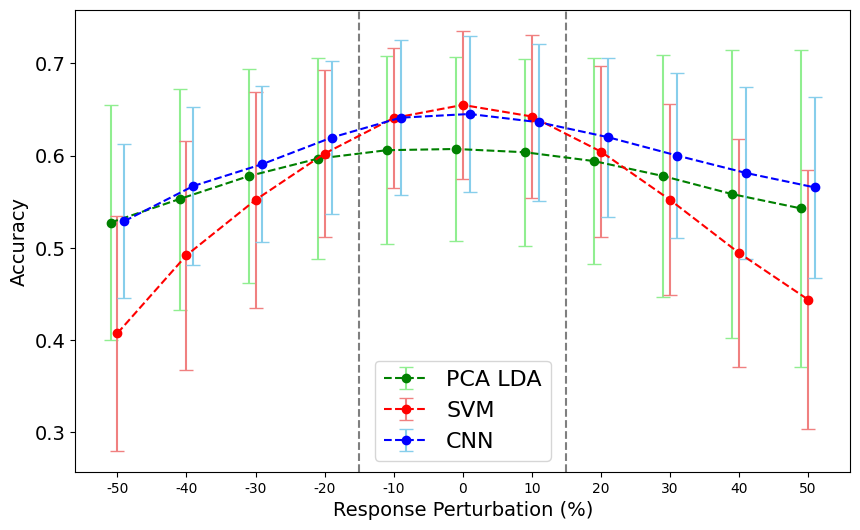

In [ ]:
dummy_x = np.linspace(0,len(p_values)-1, len(p_values))

plt.figure(figsize=(10, 6))
plt.errorbar(dummy_x-0.1, np.mean(lda_accuracy_by_order, axis=0), yerr=np.std(lda_accuracy_by_order, axis=0), fmt='--go', ecolor='lightgreen',color='green',label='PCA LDA', capsize=5)
plt.errorbar(dummy_x, np.mean(svm_accuracy_by_order, axis=0), yerr=np.std(svm_accuracy_by_order, axis=0), fmt='--ro', ecolor='lightcoral',color='r',label='SVM', capsize=5)
plt.errorbar(dummy_x+0.1, np.mean(cnn_accuracy_by_order, axis=0), yerr=np.std(cnn_accuracy_by_order, axis=0), fmt='--bo', ecolor='skyblue',color='blue',label='CNN', capsize=5)
plt.xlabel('Response Perturbation (%)', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(dummy_x, p_values)
plt.yticks(fontsize=14)
plt.axvline(x=3.5, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=6.5, color='black', linestyle='--', alpha=0.5)
plt.legend(loc = 'lower center', fontsize="16")
plt.savefig("HiRes_Response_Perturbation", dpi=300)
plt.show()